<div class="alert alert-block alert-info">
    <h1>MSDS 629 - 01 - Final project</h1>
    Due Friday Jan 19th 11:59pm PST

In [2]:
from itertools import product
from itertools import combinations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

<div class="alert alert-block alert-warning">  
<h3> [Experiment design] - First Run </h3>

In [3]:
design_factors = {
    'Tile Size' : {
        'code_name' : 'Tile.Size',
        'default' : 0.2
    },
    'Match Score' : {
        'code_name' : 'Match.Score',
        'default' : 95

    },
    'Preview Length' : {
        'code_name' : 'Prev.Length',
        'default' : 75
    },
    'Preview Type' : {
        'code_name' : 'Prev.Type',
        'default' : 'TT'
    }
}

def generate_experiment(factors, ranges):
    """Given factors and ranges (corresponding list of possible levels on each factor,
    Return the experiment format dataframe

    Args:
        factors (list): list of factor names (specified in final project description pdf)
        ranges (list): list of iterables (possible levels on each factor)

    Returns:
        pd.DataFrame: experiment format dataframe (you can save it to csv and upload the csv file directly)
    """
    header = [design_factors[factor]['code_name'] for factor in factors]
    conditions = list(product(*ranges))
    df = pd.DataFrame(conditions, columns=header)
    return df



In [4]:
factors=[
        'Preview Length', 
        'Match Score', 
        'Tile Size',
        'Preview Type'
]

ranges=[
        np.linspace(30, 120, 2, dtype=int),
        np.linspace(0, 100, 2, dtype=int),
        np.linspace(0.1, 0.5, 2, dtype=float),
        ['TT', 'AC']
]

factorial_experiments = generate_experiment(
    factors=factors,
    ranges=ranges
)
print(f'The number of experiments: {len(factorial_experiments)}')

The number of experiments: 16


<div class="alert alert-danger">
⚠️ Warning: do not use <b> our team name </b> until you finalize the experiment plan with your teammates
</div>

In [5]:
submit_id = "NSTEVENS"

In [6]:
factorial_experiments.to_csv(f"{submit_id}.csv", index=False)

<div class="alert alert-block alert-warning">  
<h3> [Analysis] </h3>

In [9]:
results_csv_file_path = "RESULTS_NSTEVENS_CumCondCount=89907_2024-01-16.csv"
response = pd.read_csv(f"{results_csv_file_path}")

In [10]:
# Rename the columns so that you can use the dataframe in linear regression analysis
response = response.rename(
    columns={
        column : column.split(".")[1] for column in response.columns
    }
)
response.columns

Index(['Length', 'Score', 'Size', 'Type', 'Time'], dtype='object')

<div class="alert alert-block alert-success">  
Check the overall distribution of responses
</div>

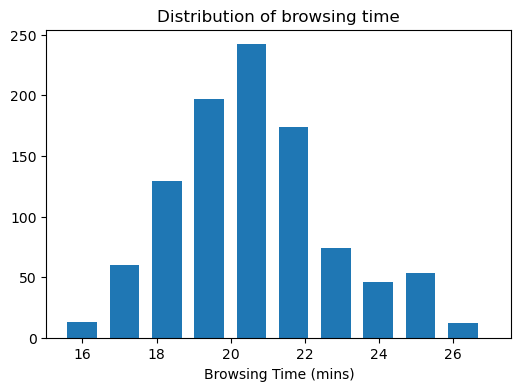

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(response.Time, width=0.8)
ax.set_xlabel("Browsing Time (mins)")
ax.set_title("Distribution of browsing time")
plt.show()

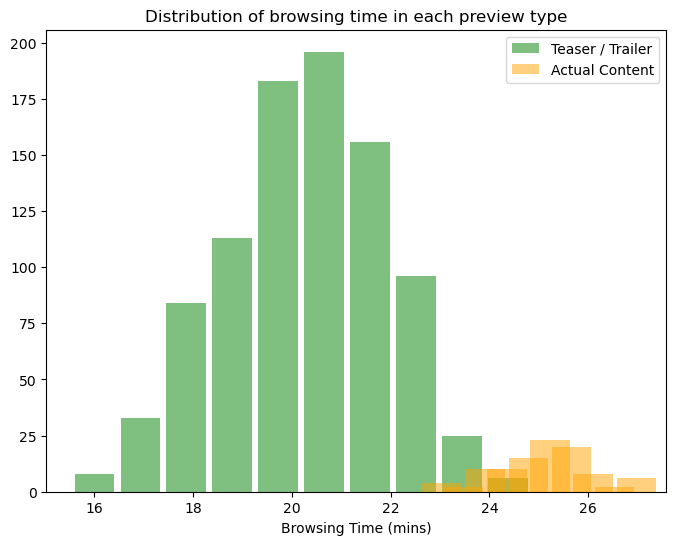

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

teaser_trailer = response[response['Type'] == 'TT']
actual_content = response[response['Type'] == 'AC']
ax.hist(teaser_trailer.Time, width=0.8, color='green', alpha=0.5, label='Teaser / Trailer')
ax.hist(actual_content.Time, width=0.8, color='orange', alpha=0.5, label='Actual Content')
ax.set_xlabel("Browsing Time (mins)")
ax.set_title("Distribution of browsing time in each preview type")
ax.legend()
plt.show()

> Since the overall distribution doesn't seem to follow normal distribution  
> From now on, let's look at the responses only from `TT` type which seems to have lower average browsing time.

<div class="alert alert-block alert-success">  
Model set-up
</div>

In [13]:
predictors = []
for factor in factors:
    predictor = f'C({design_factors[factor]["code_name"].split(".")[1]})'
    if factor == "Preview Type":
        continue
        # predictor = f'C({predictor})'
    predictors.append(predictor)

main_effects = " + ".join(list(predictors))

two_factor_interactions = " + ".join([f"{a} : {b}" for a, b in combinations(predictors, 2)])

three_factor_interactions = " + ".join([f"{a} : {b} : {c}" for a, b, c in combinations(predictors, 3)])

In [14]:
full_model_str = f'Time ~ {main_effects} + {two_factor_interactions} + {three_factor_interactions}'

> Since the number of experiments in total is very small (< 40),  
> I am going to consider all the factors as categorical variables.

<div class="alert alert-block alert-success">  
Check multicoolinearity
</div>

In [302]:
y, X = dmatrices(full_model_str, data=teaser_trailer, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

   VIF Factor                                         features
0         8.0                                        Intercept
1         4.0                                 C(Length)[T.120]
2         4.0                                  C(Score)[T.100]
3         4.0                                   C(Size)[T.0.5]
4         6.0                 C(Length)[T.120]:C(Score)[T.100]
5         6.0                  C(Length)[T.120]:C(Size)[T.0.5]
6         6.0                   C(Score)[T.100]:C(Size)[T.0.5]
7         7.0  C(Length)[T.120]:C(Score)[T.100]:C(Size)[T.0.5]


> All the predictors have VIF less than 10  
> No action required regarding multicollinearity

<div class="alert alert-block alert-success">  
Optimize the model size
</div>

In [15]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
# full model : main effect + two-factor interaction + three-factor interaction
full_model = smf.ols(full_model_str, data=teaser_trailer).fit()
# proposed model 1 : main effect + two-factor interaction
reduced_model_1 = smf.ols(f'Time ~ {main_effects} + {two_factor_interactions}', data=teaser_trailer).fit()
sm.stats.anova_lm(reduced_model_1, full_model)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,891.0,979.157404,0.0,NaN,NaN,NaN
1,891.0,978.895218,-0.0,0.262186,-inf,NaN


In [16]:
# proposed model 2 : main effect (only main effect)
reduced_model_2 = smf.ols(f'Time ~ {main_effects}', data=teaser_trailer).fit()
sm.stats.anova_lm(reduced_model_2, full_model)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,894.0,1041.216566,0.0,NaN,NaN,NaN
1,891.0,978.895218,3.0,62.321348,18.9085,6.786924e-12


In [20]:
# model summaries
# full_model.summary()
# reduced_model_1.summary()
reduced_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Time   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     236.9
Date:                Mon, 15 Jan 2024   Prob (F-statistic):          4.95e-161
Time:                        19:13:13   Log-Likelihood:                -1342.6
No. Observations:                 900   AIC:                             2697.
Df Residuals:                     894   BIC:                             2726.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           18.5881      0.077    240.112      0.000      18.436      18.740
C(Length)[T.110]  -2.86e+12   6.88e+12     -0.415      0.678   -1.64e+13    1.07e+13
C(Length)[T.120]     2.3441      0.076     30.708      0.000       2.194       2.494
C(Score)[T.90]     2.86e+12   6.88e+12      0.415      0.678   -1.07e+13    1.64e+13
C(Score)[T.100]      1.1737      0.076     15.372      0.000       1.024       1.324
C(Size)[T.0.3]      -0.0257      0.076     -0.337      0.736      -0.176       0.124
==============================================================================
Omnibus:                        1.024   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.599   Jarque-Bera (JB):                1.055
Skew:                           0.008   Prob(JB):                        0.590
Kurtosis:                       2.833   Cond. No.                     3.66e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.23e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [17]:
limits = [teaser_trailer['Time'].mean()-1, teaser_trailer['Time'].mean()+1]

def two_factor_interaction_plot(column_a: str, column_b: str):
    fig, axes = plt.subplots(ncols=3, figsize=(20, 4))
    abt_a = teaser_trailer.groupby(by=column_a)['Time'].mean()
    axes[0].scatter(abt_a.index, abt_a, color='grey')
    axes[0].plot(abt_a.index, abt_a, linestyle='dotted', c='grey')
    axes[0].set_xticks(abt_a.index)
    axes[0].set_xlabel(column_a)
    axes[0].set_ylabel("Average Browsing Time (mins)")
    axes[0].set_ylim(*limits)

    abt_b = teaser_trailer.groupby(by=column_b)['Time'].mean()
    axes[1].scatter(abt_b.index, abt_b, color='grey')
    axes[1].plot(abt_b.index, abt_b, linestyle='dotted', color='grey')
    axes[1].set_xticks(abt_b.index)
    axes[1].set_xlabel(column_b)
    axes[1].set_ylabel("Average Browsing Time (mins)")
    axes[1].set_ylim(*limits)
    
    for value_b in teaser_trailer[column_b].unique():
        temp = teaser_trailer[teaser_trailer[column_b] == value_b].groupby(column_a)['Time'].mean()
        axes[2].scatter(temp.index, temp, label=f'{column_b}: {value_b}')
        axes[2].plot(temp.index, temp)
        axes[2].set_xlabel(column_a)
    axes[2].legend()
    axes[2].set_ylim(*limits)

    fig.suptitle(f'{column_a} vs {column_b}', fontsize=16)
    plt.show()

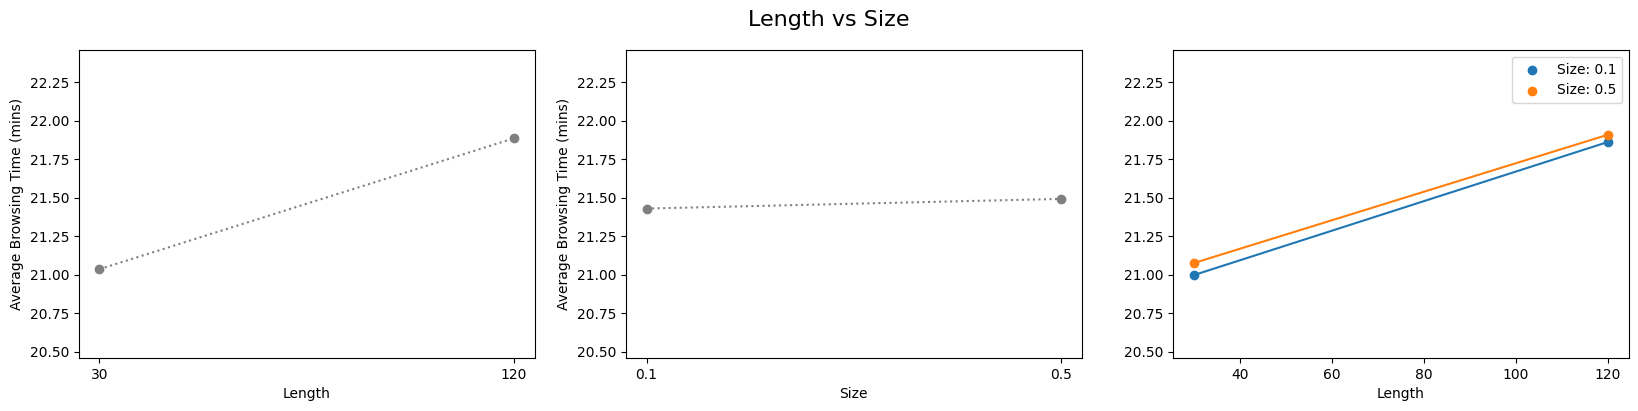

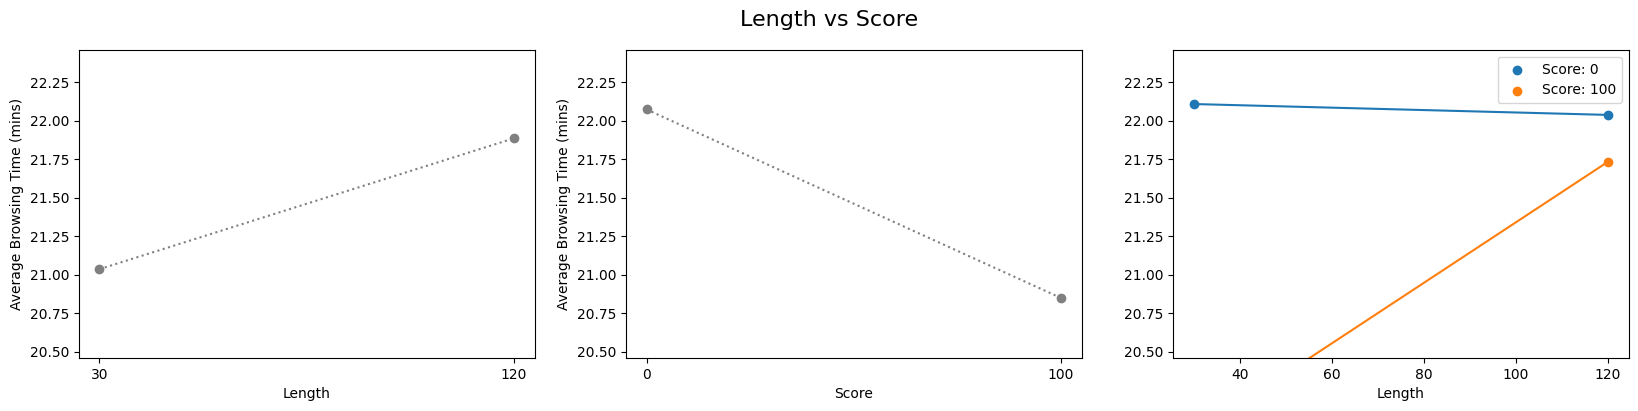

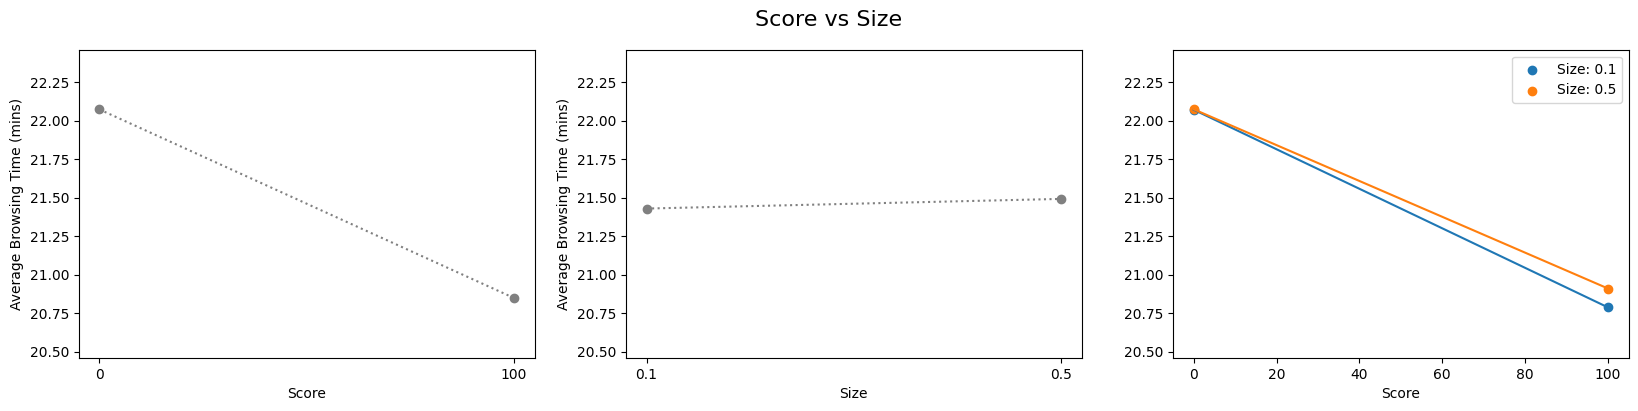

In [306]:
two_factor_interaction_plot("Length", "Size")
two_factor_interaction_plot("Length", "Score")
two_factor_interaction_plot("Score", "Size")